In [281]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import investpy
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Download stock data

In [283]:
all_stocks = investpy.get_stocks_list(country='United States')
#all_stocks = investpy.etfs.get_etfs_list('united states')
print('There are {} etfs'.format(str(len(all_stocks))))
stocks_selected = all_stocks[:200]
print('out of which '+  str(len(stocks_selected)) + ' are chosen')

There are 4582 etfs
out of which 200 are chosen


In [284]:
#stocks_selected = ' '.join(stocks_selected)
data = yf.download(stocks_selected, start = "2010-01-02", end = "2020-09-05")

[*********************100%***********************]  200 of 200 completed

4 Failed downloads:
- EUHMF: No data found, symbol may be delisted
- BBT: No data found, symbol may be delisted
- CELG: No data found, symbol may be delisted
- PJC: No data found, symbol may be delisted


In the paper, authors drop all assets that contain at least 1 non-traded day (nan). But if we do this here, no stocks would be left at all, so we interpolate missing values

In [285]:
close = data[['Adj Close']].dropna(axis = 1, how = 'all', thresh = data.shape[0] * 0.95) #drop stock if 5% of days are absent
close = close.fillna(0)
close.columns = close.columns.droplevel(0)
close.index = pd.to_datetime(close.index)
close.index = close.index.to_period(freq='d')
print(str(close.shape[1]) + ' stocks left')

184 stocks left


In [286]:
close.head(3)

,AA,AAPL,AAXN,ACN,ADBE,ADI,ADSK,AGN,AKAM,AMAT,...,WAT,WYNN,XEL,XLNX,XOM,XRAY,YGEHY,YRCW,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,37.018944,6.604801,4.65,33.595993,37.090000,24.001997,25.670000,37.54055,25.920000,11.516642,...,61.630001,41.963718,14.223065,19.886999,47.467609,33.034389,164.300003,5400.0,55.568928,11.827960
2010-01-05,35.862801,6.616219,4.70,33.803631,37.700001,23.964100,25.280001,37.16785,26.690001,11.428047,...,60.790001,44.515926,14.054389,19.636250,47.652931,32.641670,185.000000,5100.0,57.328018,12.244997
2010-01-06,37.730419,6.510980,5.84,34.162979,37.619999,23.918631,25.340000,37.28899,26.469999,11.403889,...,60.900002,43.932011,14.081378,19.503048,48.064804,32.856728,179.699997,6075.0,57.309509,13.309779


In [287]:
returns = close.pct_change().iloc[1:, :]#fill_method='ffill').iloc[1:, :]
returns = returns.replace([np.inf, -np.inf], np.nan)
returns = returns.dropna(axis = 0)
returns = returns.fillna(0)
returns.head(3)

,AA,AAPL,AAXN,ACN,ADBE,ADI,ADSK,AGN,AKAM,AMAT,...,WAT,WYNN,XEL,XLNX,XOM,XRAY,YGEHY,YRCW,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.031231,0.001729,0.010753,0.006180,0.016446,-0.001579,-0.015193,-0.009928,0.029707,-0.007693,...,-0.013630,0.060819,-0.011859,-0.012609,0.003904,-0.011888,0.125989,-0.055556,0.031656,0.035259
2010-01-06,0.052077,-0.015906,0.242553,0.010630,-0.002122,-0.001897,0.002373,0.003259,-0.008243,-0.002114,...,0.001810,-0.013117,0.001920,-0.006783,0.008643,0.006588,-0.028649,0.191176,-0.000323,0.086957
2010-01-07,-0.021214,-0.001848,-0.030822,-0.000935,-0.019405,-0.007921,0.005525,-0.007996,0.000378,-0.010593,...,0.004269,0.021356,-0.004312,-0.010044,-0.003142,0.013091,0.003339,0.049383,0.022940,0.112000


### Filter with AR(1)-TGARCH(1,1,1)

In [288]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model 
from arch.univariate import ARX, GARCH, StudentsT

In [289]:
all_ret = np.full((returns.shape[0]-1, returns.shape[1]), 0, dtype = 'float64')

for col in range(returns.shape[1]):
    
    #mod = HARX(close.iloc[:599], lags = [1, 2], rescale = False)
    #mod.volatility = GARCH(p=1, o=1, q=1)
    #mod.distribution = StudentsT()
    order = 10 / returns.iloc[:, col].std()
    mod = arch_model(order * returns.iloc[:, col],
                    mean='ARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='skewstudent')#, rescale = False)#    StudentsT') 
    mod_fit = mod.fit(options = {'maxiter':500}, disp='off', show_warning = False)
    all_ret[:, col] = mod_fit.resid[1:] / mod_fit.conditional_volatility[1:] 
all_ret = pd.DataFrame(all_ret, index = returns.index[1:], columns = returns.columns, dtype = 'float64')

In [290]:
all_res = np.full((close.shape[0] - 1, close.shape[1]), 0,  dtype = 'float64')

for col in range(close.shape[1]):
       # mod = ARX(100 * returns.iloc[:, col], lags = [1, 2,])
       # mod.volatility = GARCH(p=1, o=1, q=1)
       # mod.distribution = StudentsT()
    """order = 0
    if (close.iloc[:, col] >= 1000).all():
        order = 0.01
    elif (close.iloc[:, col] < 1).all():
        order = 100
    else:
        order = 1"""
    order = 10 / close.iloc[:, col].std()
    mod = arch_model(order * close.iloc[:, col],
                        mean='ARX', lags = 1, # mean = Constant, ARX, HARX + the number of lags
                        vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                        dist='skewstudent')#, rescale=False)#    StudentsT') 
    mod_fit = mod.fit(options = {'maxiter':500}, disp='off',  show_warning = False)
    all_res[:, col] = mod_fit.resid[1:] / mod_fit.conditional_volatility[1:] 
all_res = pd.DataFrame(all_res, index = close.index[1:], columns = close.columns, dtype = 'float64')

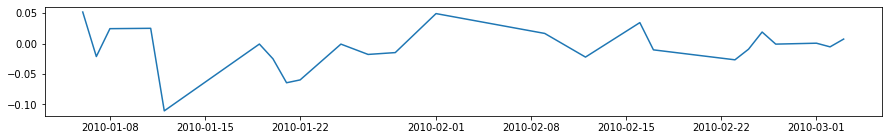

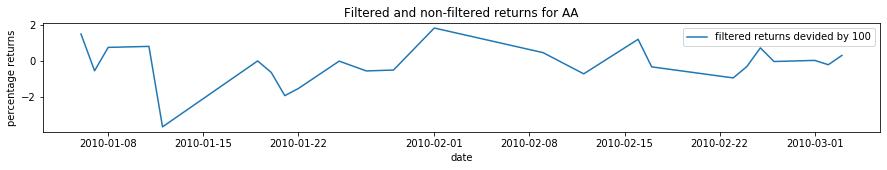

In [291]:
plt.figure(figsize = (15, 2))
plt.plot(returns.index.to_timestamp()[1:25], returns.iloc[1:25, 0], label = 'non-filtered returns');
plt.figure(figsize = (15, 2))
plt.plot(returns.index.to_timestamp()[1:25], all_ret.iloc[:24, 0], label = 'filtered returns devided by 100');
plt.title('Filtered and non-filtered returns for {}'.format(all_ret.columns[0]))
plt.legend()
plt.xlabel('date')
plt.ylabel('percentage returns');

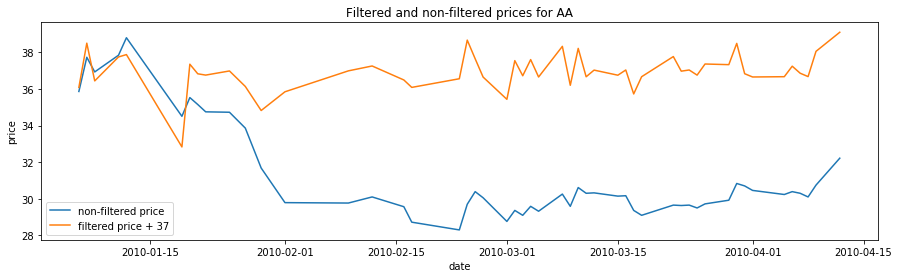

In [292]:
plt.figure(figsize = (15,4))
plt.plot(returns.index.to_timestamp()[1:51], close.iloc[1:51, 0], label = 'non-filtered price');
plt.plot(returns.index.to_timestamp()[1:51], all_res.iloc[:50, 0] + 37, label = 'filtered price + 37');
plt.title('Filtered and non-filtered prices for {}'.format(all_res.columns[0]))
plt.legend()
plt.xlabel('date')
plt.ylabel('price');

In [293]:
#split in training, validation and test sets
#THESE ARE FILTERED PRICES
price_train = all_res.loc[:'2019-01-01', :]
price_val = all_res.loc['2019-01-01':'2020-01-01']
price_test = all_res.loc['2020-01-01':]
#THESE ARE NON-FILTERED PRICES
raw_price_train = close.loc[:'2019-01-01', :]
raw_price_val = close.loc['2019-01-01':'2020-01-01']
raw_price_test = close.loc['2020-01-01':]
# returns filtered
filt_ret = all_ret.loc[:'2019-01-01', :]

### PCA dimensionality reduction and OPTICS clustering
   The authors use 15 principal components in PCA but we use a larger number due to the fact that out time series is longer (authors had 8 years of training data) and it could be we cannot describe it well in 15 components. Then, these components serve as input to OPTICS - density based clustering method. To choose among models, we use silhouette score. It is in range between -1 and 1, the higher it is the better.

In [294]:
def find_max(silhouette):
    all_vals = []
    for val in silhouette.values():
        all_vals.extend(val)
    return all_vals

def best_params(silhouette):
    all_vals = find_max(silhouette)
    max_val = max(all_vals)
    for key, val in silhouette.items():
        if max_val in val:
            return key, val.index(max_val) + 2, max_val

In [295]:
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score

silhouette = dict()
for comp in range(2, 16):
    partial_silh = list()
    pca = PCA(n_components = comp, svd_solver = 'auto')
    pca_fit = pca.fit_transform(filt_ret.transpose())
    for min_sampl in range(2, 7):
        try:
            clusters = OPTICS(min_samples = min_sampl).fit(pca_fit) #metric = 'euclidean' min_cluster_size = 5
            partial_silh.append(silhouette_score(pca_fit, clusters.labels_))
        except: pass
    silhouette[comp] = partial_silh
    
best_comp, best_min_smpl, best_score = best_params(silhouette)
print('best silhouette_score is ' + str(best_score) + ' at ' + str(best_min_smpl) + ' min_samples and ' +
      str(best_comp) + ' components')

best silhouette_score is 0.20553507975424362 at 2 min_samples and 2 components


In [296]:
pca = PCA(n_components = best_comp, svd_solver = 'auto')
pca_fit = pca.fit_transform(filt_ret.transpose())
clusters = OPTICS(min_samples = best_min_smpl).fit(pca_fit)

Number of clusters is 52


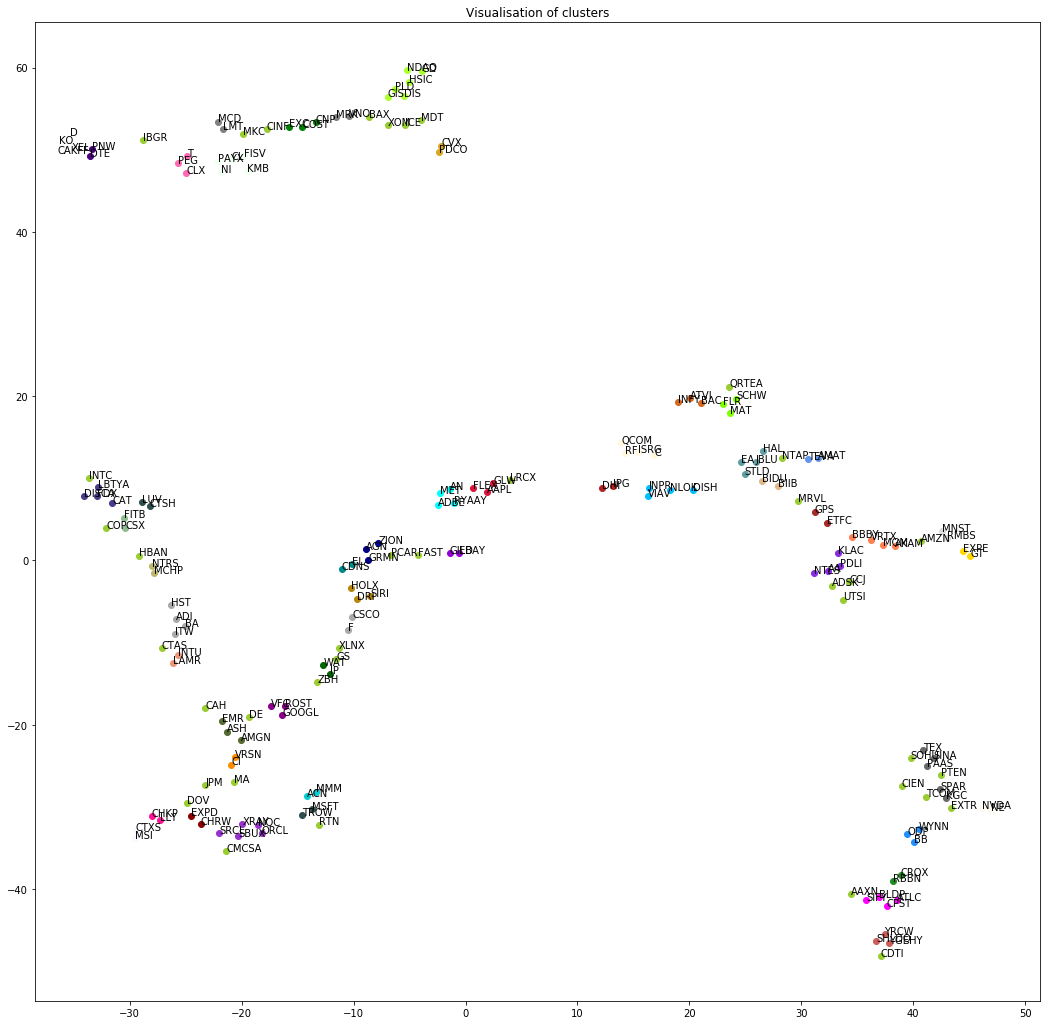

In [297]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

tsne = TSNE(n_components = 2, perplexity = 6).fit_transform(pca_fit)

print('Number of clusters is ' + str(clusters.labels_.max()-clusters.labels_.min()))
colors = list(mcolors.CSS4_COLORS.keys())[10:]
plt.figure(figsize=(18,18))
for klass in range(clusters.labels_.min(), clusters.labels_.max()):
    plt.scatter(tsne[clusters.labels_ == klass][:, 0], tsne[clusters.labels_ == klass][:, 1],
               c = colors[klass], label = 'class {}'.format(str(klass)))
for i, txt in enumerate(filt_ret.columns):
    plt.annotate(txt, (tsne[i, 0], tsne[i, 1]))
#plt.legend()
plt.title('Visualisation of clusters');

In [298]:
#do not include class -1 since these are outliers/points without claster
def make_classes(df):
    classes = dict()
    for cl in range(0, clusters.labels_.max()): 
        klass = df.transpose()[clusters.labels_ == cl]
        classes[cl] = klass
    return classes

In [299]:
raw_classes = make_classes(raw_price_train)

### Select pairs
Next, we select pairs based on the following criteria:
- cointegration
- Hurst exponent < 0.5
- half-life of mean reversion
- average number of crossings of spread mean per year

In [300]:
from statsmodels.tsa.stattools import coint
from hurst import compute_Hc
from scipy.ndimage.interpolation import shift
from sklearn import linear_model

In [301]:
def compose_pairs(classes):
    pairs = list()
    for cl in classes.keys():
        tested_pairs = list()
        for smpl in range(classes[cl].shape[0]):
            for smpl2 in range(classes[cl].shape[0]):
                if smpl != smpl2 and (smpl2, smpl) not in tested_pairs: #no cointegration with itself, check pair has not been tested
                    tested_pairs.append((smpl2, smpl))
                    cointegrated = coint(classes[cl].iloc[smpl, :], classes[cl].iloc[smpl2, :], return_results = True)
                    if cointegrated[1] < 0.05: #pvalue
                        pairs.append([classes[cl].iloc[smpl, :], classes[cl].iloc[smpl2,:]])
    #pairs = pairs[1:]#the first pair is repeated
    print('There are {} pairs at cointegration stage'.format(len(pairs)))
    return pairs

In [302]:
#check spread mean-reversion
def calc_Hurst(pairs):
    for pair in pairs:
        spread = pair[0] - pair[1]
        H, c, data = compute_Hc(spread)
        if H >= 0.5: #Brownian motion or persistent
            for ts in pair:
                pair.remove(ts)
            pairs.remove(pair)
    print('There are {} pairs at Hurst stage'.format(len(pairs)))
    return pairs

In [303]:
#check mean-reversion half life
# https://letianzj.github.io/mean-reversion.html

def calc_half_life(pairs):
    lin_reg = linear_model.LinearRegression()
    for pair in pairs:
        for ts_n, ts in enumerate(pair):
            ts_delta = ts - ts.shift()
            lin_reg.fit(np.array(ts.shift()[1:]).reshape(-1,1), np.array(ts_delta[1:]).reshape(-1,1)) 
            half_life = -np.log(2) / lin_reg.coef_.item()
            if half_life < 1 or half_life > 365:
                del pair[ts_n]
                pairs.remove(pair)
                break
    print('There are {} pairs at mean-reversion half life stage'.format(len(pairs)))
    return pairs

In [304]:
#check that on average there are at least 12 crossings of spread mean per year
def number_mean_reversions(pairs):
    years_num  = len(price_train.index.to_timestamp().year.unique())
    for pair in pairs:
        spread = pair[0] - pair[1]
        crosses = 0
        for i in range(len(spread) - 1):
            if (spread[i] > spread.mean() and spread[i + 1] < spread.mean()) or (spread[i] < spread.mean() and spread[i + 1] > spread.mean()):
                crosses += 1
        if crosses < 12 * years_num:
            for ts in pair:
                pair.remove(ts)
            pairs.remove(pair)
    print('There are {} pairs at calculation of mean-reversions number stage'.format(len(pairs)))
    return pairs

In [305]:
raw_pairs = compose_pairs(raw_classes)
raw_pairs = calc_Hurst(raw_pairs)
raw_pairs = calc_half_life(raw_pairs)
raw_pairs = number_mean_reversions(raw_pairs)

There are 26 pairs at cointegration stage
There are 24 pairs at Hurst stage
There are 24 pairs at mean-reversion half life stage
There are 12 pairs at calculation of mean-reversions number stage


In [306]:
plt.figure(figsize = (15, 4))
plt.plot(pairs[0][0].index.to_timestamp()[:50], pairs[0][0][:50], label = pairs[0][0].name)
plt.plot(pairs[0][1].index.to_timestamp()[:50], pairs[0][1][:50], label = pairs[0][1].name)
plt.legend()
plt.xlabel('date')
plt.ylabel('filtered price')
plt.title('Filtered prices of {} and {}'.format(pairs[0][0].name, pairs[0][1].name));

NameError: name 'pairs' is not defined

<Figure size 1080x288 with 0 Axes>

In [ ]:
#Попробовать на нефильтрованных данных
plt.figure(figsize = (15, 4))
plt.plot(pairs[0][0].index.to_timestamp(), close.loc[pairs[0][0].index, ('Adj Close',pairs[0][0].name)], label = pairs[0][0].name)
plt.plot(pairs[0][1].index.to_timestamp(), close.loc[pairs[0][1].index, ('Adj Close',pairs[0][1].name)], label = pairs[0][1].name)
plt.legend()
plt.xlabel('date')
plt.ylabel('price')
plt.title('Prices of {} and {}'.format(pairs[0][0].name, pairs[0][1].name));

### Spread prediction

In [307]:
def spread_change(spread):
    spread_chg = (spread.shift(-1) - spread)[:-1]
    #spread[spread == 0] = 0.00000001 #to avoid division by zero
    spread_chg = spread_chg / spread[:-1]
    return spread_chg

In [27]:
#formation period - train set
#pairs - filtered prices but need to use ordinary ones
spread = pairs[0][0] - pairs[0][1]
spread_chg = spread_change(spread)

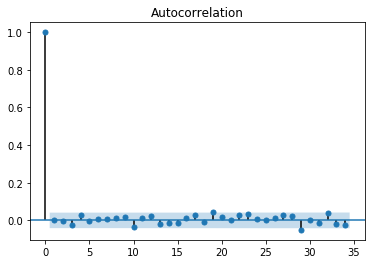

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(spread); #it is rather small, so try lags in range of 1

In [38]:
q = np.quantile(spread_chg, [0.2, 0.8], interpolation = 'linear')
d = np.quantile(spread_chg, [0.1, 0.9], interpolation = 'linear')

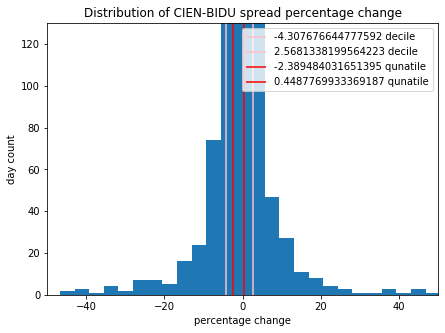

In [31]:
plt.figure(figsize=(7, 5))
plt.hist(spread_chg, bins = 500)
plt.title('Distribution of {}-{} spread percentage change'.format(pairs[0][0].name, pairs[0][1].name))
plt.xlabel('percentage change')
plt.ylabel('day count')
for dec in d:
    plt.vlines(dec, 0, 130, colors = 'pink', label = '{} decile'.format(dec))
for quant in q:
    plt.vlines(quant, 0, 130, colors = 'red', label = '{} qunatile'.format(quant))
plt.legend()
plt.xlim(-50, 50)
plt.ylim(0,130);

In [321]:
def trade(a_sh, a_lo, window, account, price_pred, price_val, name1, name2):
    portfolio_value_list = []
    acc_return_list = []
    cap_invested = []
    comission = 0.001
    stock1 = 0
    stock2 = 0
    acc_return = 0.0
    prev_capital = 0.0
    prev_price1 = 0.0
    prev_price2 = 0.0
    prev_stock1 = 0
    prev_stock2 = 0
    start_idx = 0
    trade_indicator = 'no_trade'
    portfolio_value = 0
    end_idx = start_idx + window + 1 #last observation is not included
    resid = 0.0
    while end_idx <= price_val.shape[0] - 1:
        p1 = price_pred[name1][start_idx:end_idx]
        p2 = price_pred[name2][start_idx:end_idx]
        if (p1 < 0).any():
            p1[p1 < 0] = -p1[p1 < 0]
        if (p2 < 0).any():
            p2[p2 < 0] = -p2[p2 < 0]
        spread = p1 - p2
        arma = ARIMA(np.array(spread), order = (1,0,1)).fit()
        pred = arma.forecast(steps=1, exog=None, alpha=0.01)
        pred_chg = (pred - spread[-1:] / spread[-1:])[0]
        
        price1 = price_val.loc[spread[-1:].index, name1][0]
        price2 = price_val.loc[spread[-1:].index, name2][0]
        if price1 < 0:
            price1 = - price1
        if price2 < 0:
            price2 = - price2
        portfolio_value = resid + stock1 * price1 + stock2 * price2 #portfolio revaluation 
        portfolio_value_list.append(portfolio_value)
        
        if price1 != 0 and price2 != 0: #if stock was traded
            if trade_indicator == 'short':
                acc_return += ((prev_price1 - price1)*prev_stock1 + (price2 - prev_price2)*prev_stock2) / prev_capital
            elif trade_indicator == 'long':
                acc_return += (prev_price2 - price2)*prev_stock2 + (price1 - prev_price1)*prev_price1 / prev_capital
            acc_return_list.append(acc_return)
            
            if pred_chg <= a_sh:
                trade_indicator = 'short'
                deal1 = stock1 * price1 * (1 - comission) #sell stock1
                if stock1 != 0:
                    prev_stock1 = stock1
                if deal1 > allocated_capital: 
                    stock1_to_sell = allocated_capital // (price1 * (1 - comission))
                    deal1 = stock1_to_sell * price1 * (1 - comission)
                    stock1 -= stock1_to_sell
                    if stock1_to_sell != 0:
                        prev_stock1 = stock1_to_sell
                else:
                    stock1 = 0
                account += deal1
                stock_2_bought = account // (price2 * (1 + comission))
                deal2 = stock_2_bought * price2 * (1 + comission) #buy stock2
                if deal2 > allocated_capital:
                    stock_2_bought = allocated_capital // (price2 * (1 + comission))
                    deal2 = stock_2_bought * price2 * (1 + comission)
                account -= deal2
                resid = account
                stock2 += stock_2_bought

                if deal1+deal2 != 0:
                    prev_capital = deal1+deal2
                    cap_invested.append(prev_capital)
                if stock_2_bought != 0:
                    prev_stock2 = stock_2_bought

            elif pred_chg >= a_lo:
                trade_indicator = 'long'
                deal2 = stock2 * price2 * (1 - comission) #sell stock2
                if stock2 != 0:
                    prev_stock2 = stock2
                if deal2 > allocated_capital:
                    stock2_to_sell = allocated_capital // (price2 * (1 - comission))
                    deal2 = stock2_to_sell * price2 * (1 - comission)
                    stock2 -= stock2_to_sell
                    if stock2_to_sell != 0:
                        prev_stock2 = stock2_to_sell
                else:
                    stock2 = 0
                account += deal2
                stock_1_bought = account // (price1 * (1 + comission))
                deal1 = stock_1_bought * price1 * (1 + comission) #buy stock1
                if deal1 > allocated_capital:
                    stock_1_bought = allocated_capital // (price1 * (1 + comission))
                    deal1 = stock_1_bought * price1 * (1 + comission)
                account -= deal1
                resid = account
                stock1 += stock_1_bought
                if deal1+deal2 != 0:
                    prev_capital = deal1+deal2
                    cap_invested.append(prev_capital)
                if stock_1_bought != 0:
                    prev_stock1 = stock_1_bought

            prev_price1 = price1
            prev_price2 = price2
            
        start_idx += 1
        end_idx += 1
        
    portfolio_value_list[0] = allocated_capital
    return acc_return_list, portfolio_value_list, cap_invested

def calc_returns(val_port_value, allocated_capital):
    total_returns = []
    for p in val_port_value:
            total_returns.append((p - allocated_capital) * 100 / allocated_capital)
            total_returns[0] = 0 #because at index 0 there has not been any return yet
    return total_returns 
    

In [324]:
from statsmodels.tsa.arima.model import ARIMA
from statistics import mean

def find_thresholds(pairs,price_train, price_pred, price_val, window, allocated_capital):
    chosen_params = []
    cv_profit = []

    for pair_num in range(len(pairs)):
        name1 = pairs[pair_num][0].name
        name2 = pairs[pair_num][1].name
        spread = price_train.loc[:, name1] - price_train.loc[:, name2]
        spread_chg = spread_change(spread)
        quantiles = np.quantile(spread_chg, [0.2, 0.8], interpolation = 'linear')
        deciles = np.quantile(spread_chg, [0.1, 0.9], interpolation = 'linear')

        cv_thresh_res = []
        for thresh in [quantiles, deciles]:
            val_returns, val_port_value, cap_inv = trade(thresh[0], thresh[1], window, allocated_capital, price_pred, price_val, name1, name2) 
            total_returns = calc_returns(val_port_value, allocated_capital)
            cv_thresh_res.append(mean(total_returns)) #not sum but mean
            #cv_thresh_res.append(account)
        best_thresh = cv_thresh_res.index(max(cv_thresh_res))
        if best_thresh == 0:
            chosen_params.append(pd.Series(quantiles,name = pairs[pair_num][0].name + '-' + pairs[pair_num][1].name))
        else:
            chosen_params.append(pd.Series(deciles, name = pairs[pair_num][0].name + '-' + pairs[pair_num][1].name))
        max_profit =  max(cv_thresh_res)
        cv_profit.append(pd.Series(max_profit, name = pairs[pair_num][0].name + '-' + pairs[pair_num][1].name))
    return cv_profit, chosen_params

In [325]:
allocated_capital = 500000 #Further we will chose 5 stocks
raw_cv_profit, raw_chosen_params = find_thresholds(raw_pairs, raw_price_train, raw_price_val, raw_price_val, 150, allocated_capital)

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed 

In [326]:
def find_best_pairs(cv_profit):
    profitable = 0
    unprofitable = 0
    profitable_pairs = []
    for trade in cv_profit:
        if trade[0]> 0: 
            profitable += 1
            profitable_pairs.append(trade)
        else: 
            unprofitable += 1
    print('There are {} profitable and {} unprofitable pairs'.format(profitable, unprofitable)) 
    print('These ones are profitable')
    value = []
    name = []
    for trade in profitable_pairs:
        value.append(trade[0])
        name.append(trade.name)
    df_profit_pairs = pd.DataFrame([value, name]).transpose()
    df_profit_pairs.columns = ['return', 'pair']
    df_profit_pairs.sort_values(by = 'return', inplace = True, ascending = False)
    return df_profit_pairs

In [327]:
raw_profit_pairs = find_best_pairs(raw_cv_profit)
raw_profit_pairs.head(10)

There are 6 profitable and 6 unprofitable pairs
These ones are profitable


,return,pair
0,30.9317,NTES-KLAC
3,16.6971,AMGN-ASH
2,6.75395,GOOGL-ROST
1,3.65329,MCHP-NTRS
4,3.23151,FISV-PAYX
5,3.23151,PAYX-FISV


In [328]:
def choose_from_best(number_of_pairs, df_profit_pairs, chosen_params):
    if number_of_pairs > df_profit_pairs.shape[0]:
        print('There are less than {} pairs available'.format(number_of_pairs))
        number_of_pairs = df_profit_pairs.shape[0]
    chosen_pairs = df_profit_pairs.iloc[:number_of_pairs, :]
    print('These pairs chosen are:')
    print(chosen_pairs)
    
    quantiles_chosen = []
    for pair in chosen_pairs.pair:
        for q in chosen_params:
            if q.name == pair:
                quantiles_chosen.append(np.array(q))
    return chosen_pairs, quantiles_chosen
    

In [329]:
raw_chosen_pairs, raw_quantiles = choose_from_best(5, raw_profit_pairs, raw_chosen_params)

These pairs chosen are:
    return        pair
0  30.9317   NTES-KLAC
3  16.6971    AMGN-ASH
2  6.75395  GOOGL-ROST
1  3.65329   MCHP-NTRS
4  3.23151   FISV-PAYX


In [330]:
capital = 3000000 
n_assets = raw_chosen_pairs.shape[0]
allocated_capital = 500000#capital / n_assets

In [331]:
def real_returns(quantiles_chosen, chosen_pairs, window, allocated_capital, df_pred, df_price):
    portfolio_returns = []
    portfolio_value = []
    for num, pair in enumerate(chosen_pairs.pair):
        name1, name2 = pair.split('-')
        test_ret, test_port, test_cap = trade(quantiles_chosen[num][0], quantiles_chosen[num][1], window, allocated_capital, df_pred, df_price, name1, name2)
        pair_returns = calc_returns(test_port, allocated_capital)
        portfolio_returns.append(pd.Series(pair_returns, name = pair, index = close.index[-len(pair_returns):]))
        portfolio_value.append(pd.Series(test_port, name = pair, index = close.index[-len(test_port):]))
    return portfolio_returns, portfolio_value

In [332]:
raw_returns, raw_port_value = real_returns(raw_quantiles, raw_chosen_pairs, 150, allocated_capital, raw_price_test, raw_price_test)

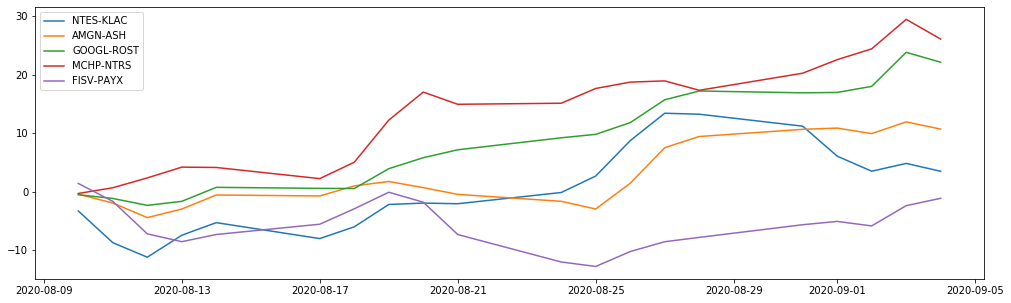

In [333]:
plt.figure(figsize = (17,5))
for n_ret, ret in enumerate(raw_returns):
    plt.plot(ret.index.to_timestamp(), ret.rolling(2).sum(), label = ret.name)
    plt.legend();

### Backtesting

#### Sharpe ratio

In [334]:
size = len(raw_returns[0])
risk_free = yf.download('^IRX', start = "2020-01-02", end = "2020-09-05")['Adj Close'][-size:]
market_idx = yf.download('^GSPC', start = "2020-01-01", end = "2020-09-05")['Adj Close'].pct_change()[1:][-size:] * 100
risk_free.index = risk_free.index.to_period(freq='d')
market_idx.index = market_idx.index.to_period(freq='d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [335]:
def sharpe(port_returns):
    interest_adj = (1 + risk_free)**(1/252) - 1 #since we are given annual rates
    for p in port_returns:
        excess_return = p - interest_adj
        sharpe = excess_return.mean() / excess_return.std()
        print('Sharpe ratio for {} is {}'.format(p.name, sharpe))
    all_returns = sum(port_returns) / len(port_returns)
    all_ex_ret = all_returns - interest_adj
    sharpe_p = all_ex_ret.mean() / all_ex_ret.std()
    print('Sharpe ratio for portfolio is {}'.format(sharpe_p))

In [343]:
sharpe(raw_returns)

Sharpe ratio for NTES-KLAC is 0.07166617304899937
Sharpe ratio for AMGN-ASH is 0.5078573337027256
Sharpe ratio for GOOGL-ROST is 0.9859237759236676
Sharpe ratio for MCHP-NTRS is 1.4021767261722382
Sharpe ratio for FISV-PAYX is -1.2445025600138917
Sharpe ratio for portfolio is 0.6818899866035282


#### Beta

In [344]:
from sklearn.linear_model import LinearRegression
def beta(results):
    portfolio_beta = 0
    for i in results:
        capm = LinearRegression(fit_intercept = True).fit(np.array(market_idx).reshape(-1, 1), np.array(i).reshape(-1, 1))
        beta = capm.coef_[0][0]
        print('beta for {} pair is {}'.format(i.name, beta))
        portfolio_beta += beta
    portfolio_beta = portfolio_beta / len(results)
    print('portfolio beta is {}'.format(portfolio_beta))

In [345]:
raw_beta = beta(raw_returns)

beta for NTES-KLAC pair is -0.003192770449356614
beta for AMGN-ASH pair is -0.9261849839933183
beta for GOOGL-ROST pair is -1.2801944020842482
beta for MCHP-NTRS pair is -0.9821601266535785
beta for FISV-PAYX pair is -1.0199522580201532
portfolio beta is -0.842336908240131


#### Maximum drawdown

In [346]:
def max_drawdown(val, allocated_capital):
    max_ = max(val)
    max_idx = list(val).index(max_)
    if max_idx != len(val) -1:
        min_ = min(val[max_idx + 1:])
    else:
        min_ = min(val)
    return (max_ - min_) * 100 / allocated_capital

In [339]:
def daily_drawdown(port_value, allocated_capital):
    sep_drawdowns = []
    for port in port_value:
        day_drawdown = port.diff().dropna()
        day_drawdown = day_drawdown * 100 / allocated_capital
        sep_drawdowns.append(day_drawdown)
        print('maximum daily drawdown for {} is {}%'.format(day_drawdown.name, round(max(day_drawdown), 2)))
    portfolio_drawdown = sum(port_value).diff().dropna() * 100 / (allocated_capital * len(port_value))
    print('maximum daily drawdown for portfolio is {}%'.format(round(max(portfolio_drawdown), 2)))
    return sep_drawdowns, portfolio_drawdown

def week_mdd(port, allocated_capital):
    weeks = port.resample('W')
    week_mdd = []
    for w in weeks:
        w_mdd = max_drawdown(w[1], allocated_capital)
        week_mdd.append(w_mdd)
    return max(week_mdd)


def weekly_drawdown(port_value, allocated_capital):
    sep_drawdowns = []
    for port in port_value:
        w_mdd = week_mdd(port, allocated_capital)
        sep_drawdowns.append(w_mdd)
        print('maximum weekly drawdown for {} is {}%'.format(day_drawdown.name, round(w_mdd, 2)))
    all_port = sum(port_value)
    portfolio_drawdown  = week_mdd(all_port, allocated_capital * len(port_value))
    print('maximum weekly drawdown for portfolio is {}%'.format(round(portfolio_drawdown, 2)))
    return sep_drawdowns, portfolio_drawdown

In [340]:
raw_day_mdd_sep, raw_day_mdd_all = daily_drawdown(raw_port_value, allocated_capital)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
raw_week_mdd_sep, raw_week_mdd_all = weekly_drawdown(raw_port_value, allocated_capital)

maximum daily drawdown for NTES-KLAC is 4.41%
maximum daily drawdown for AMGN-ASH is 5.26%
maximum daily drawdown for GOOGL-ROST is 4.12%
maximum daily drawdown for MCHP-NTRS is 4.02%
maximum daily drawdown for FISV-PAYX is 3.67%
maximum daily drawdown for portfolio is 2.92%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
maximum weekly drawdown for CDNS-CTAS is 3.91%
maximum weekly drawdown for CDNS-CTAS is 7.18%
maximum weekly drawdown for CDNS-CTAS is 5.82%
maximum weekly drawdown for CDNS-CTAS is 5.74%
maximum weekly drawdown for CDNS-CTAS is 5.8%
maximum weekly drawdown for portfolio is 3.99%


#### Accumulated return to maximum drawdown

In [341]:
def return_to_drawdown(port_value, port_returns, allocated_capital):
    for num, port in enumerate(port_value):
        mdd = max_drawdown(port, allocated_capital)
        cum_ret = port_returns[num].rolling(2).sum()[-1:]
        print('accumulated return to maximum drawdown for {} is {}'.format(port.name, round((cum_ret / mdd)[0],2)))

    port_mdd = max_drawdown(sum(raw_port_value), allocated_capital * len(port_value))
    port_returns = sum(port_returns) / len(port_returns)
    port_cum_ret = port_returns.rolling(2).sum()[-1:] 
    print('accumulated return to maximum drawdown for portfolio is {}'.format(round((port_cum_ret / port_mdd)[0],2)))

In [342]:
return_to_drawdown(raw_port_value, raw_returns, allocated_capital)

accumulated return to maximum drawdown for NTES-KLAC is 0.58
accumulated return to maximum drawdown for AMGN-ASH is 2.51
accumulated return to maximum drawdown for GOOGL-ROST is 3.8
accumulated return to maximum drawdown for MCHP-NTRS is 4.54
accumulated return to maximum drawdown for FISV-PAYX is -0.14
accumulated return to maximum drawdown for portfolio is 3.07


#### VaR and Expected Shortfall